### Задача
*Нужно проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2024-10-25 по 2024-10-31 включительно. Для эксперимента были задействованы 2 и 1 группы.* 

*В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.*

*Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.*

In [15]:
import pandahouse as ph
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pingouin as pg

Данные хранятся в Clickhouse. С помощью SQL запросим нужные данные, а с помощью pandahouse подгрузим их в датафрейм, и продолжим работу здесь в Jupyter notebook.

In [6]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'secret_password',
    'user': 'student',
    'database': 'simulator'
}

In [7]:
q = """
SELECT
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM 
    simulator_20241120.feed_actions 
WHERE 
    toDate(time) >= '2024-10-25' and toDate(time) <= '2024-10-31' AND
    exp_group in (2,1)
GROUP BY
    exp_group,
    user_id
"""

In [8]:
df = ph.read_clickhouse(q, connection=connection)

Посмотрим на распределения CTR в наших группах

<Axes: xlabel='ctr', ylabel='Count'>

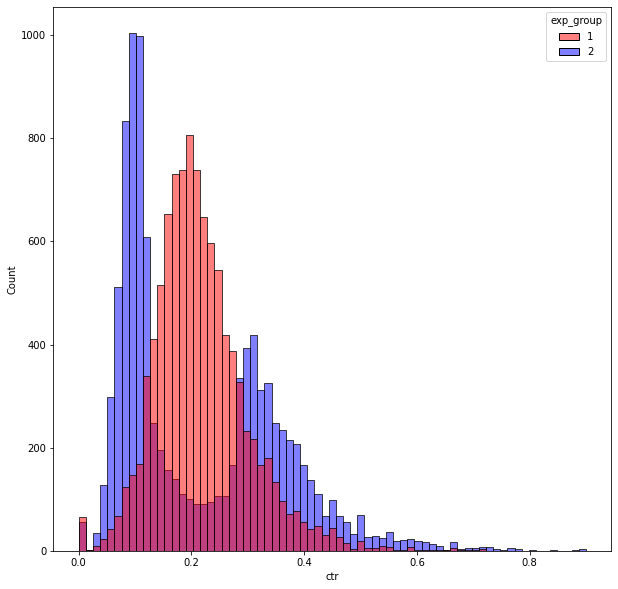

In [9]:
plt.figure(figsize=(10,10))
sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Видно, что распределения явно отличаются друг от друга. Но давайте определим их различия с помощью следующих статистических критерив:
* т-тест
* тест Манна-Уитни
* т-тест и тест Манна-Уитни на сглаженном CTR
* Пуассоновский бутстреп
* т-тест и тест Манна-Уитни поверх бакетного преобразования


Начнем с т-теста:

In [10]:
stats.ttest_ind(df.query('exp_group == 1').ctr, df.query('exp_group == 2').ctr, equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Т-тест показывает нам большой уровень значимости гипотезы о том, что средние значения CTR в наших группах равны. Но насколько т-тест подходит для наших данных, а точнее, для наших распределений? Если посмотреть распределение CTR для группы № 2, то оно явно далеко от нормального, оно имеет 2 моды, и если, распределение группы № 1 с натяжкой как-то можно назвать нормальным, то распределение 2-ой группы никак нельзя назвать нормальным. Давайте убедимся в этом с помощью тестов:

In [12]:
stats.normaltest(df.query('exp_group == 2').ctr)

NormaltestResult(statistic=887.8507350696746, pvalue=1.605692958121767e-193)

In [13]:
stats.normaltest(df.query('exp_group == 1').ctr)

NormaltestResult(statistic=1814.8208248426354, pvalue=0.0)

Text(0.5, 1.0, 'experiment (group = 2)')

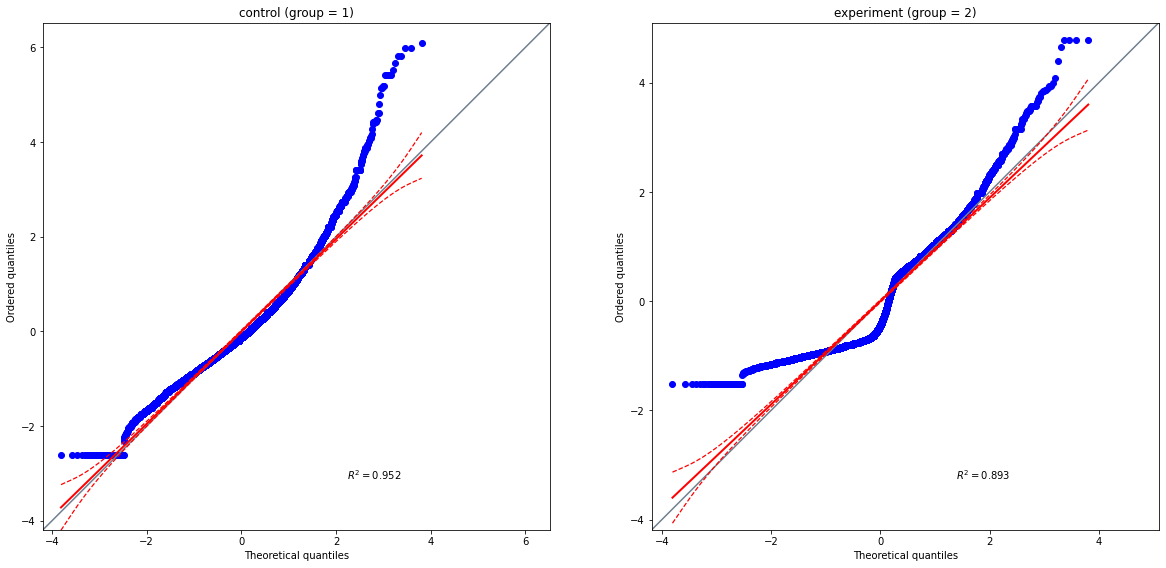

In [16]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

pg.qqplot(x=df.query('exp_group == 1').ctr, ax=axs[0])
axs[0].set_title('control (group = 1)')
pg.qqplot(x=df.query('exp_group == 2').ctr, ax=axs[1])
axs[1].set_title('experiment (group = 2)')

Из тестов на нормальность распределения видно, что ctr в группе № 2 распределение далеко от нормального (p-value = 1.6e-193). 

*Какие могут быть потенциальные ситуации, описывающие такое распределение? К примеру, у некоторой части тестовой группы в какой-то промежуток эксперимента "отвалилась" кнопка лайка, или еще ситуация, когда пользователям рекомендовались посты, которые они уже просматривали, и тем самым, они эти повторные посты уже не лайкали.* 


Попробуем тест Манна-Уитни, по идее он должен быть адекватнее, т.к. не зависит от распределения.
* тест Манна-Уитни:

In [21]:
stats.mannwhitneyu(df.query('exp_group == 1').ctr, 
                   df.query('exp_group == 2').ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Учитывая, что тест Манна-Уитни не зависит от распределения, он показывает стат значимое различие наших распределений.

Далее сгладим CTR в обеих группах (уберем шум, т.к. мы должны учитывать кол-во действий пользователя при оценке метрики отношений), и уже на сглаженных данных проведем тесты.
* Сглаживание CTR:

In [22]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [23]:
global_ctr_1 = df.query('exp_group == 1').likes.sum() / df.query('exp_group == 1').views.sum()
global_ctr_2 = df.query('exp_group == 2').likes.sum() / df.query('exp_group == 2').views.sum()

group1 = df.query('exp_group == 1').copy()
group2 = df.query('exp_group == 2').copy()

<Axes: xlabel='smothed_ctr', ylabel='Count'>

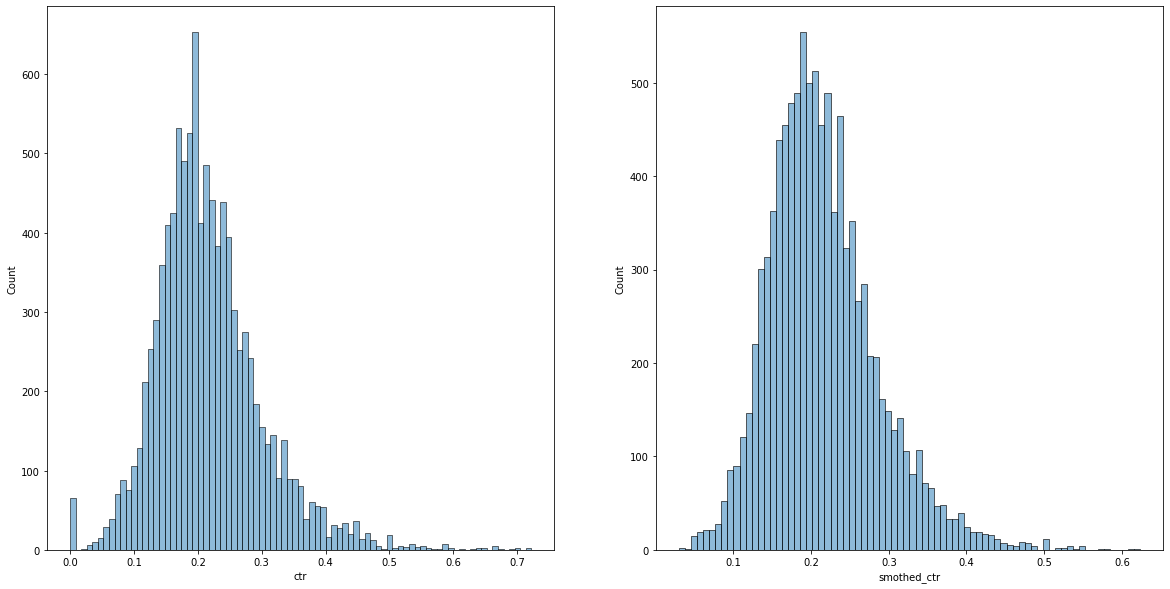

In [24]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

sns.histplot(group1, x ='ctr', alpha=0.5, ax=axs[0])

group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(group1, x ='smothed_ctr', alpha=0.5, ax=axs[1])

<Axes: xlabel='smothed_ctr', ylabel='Count'>

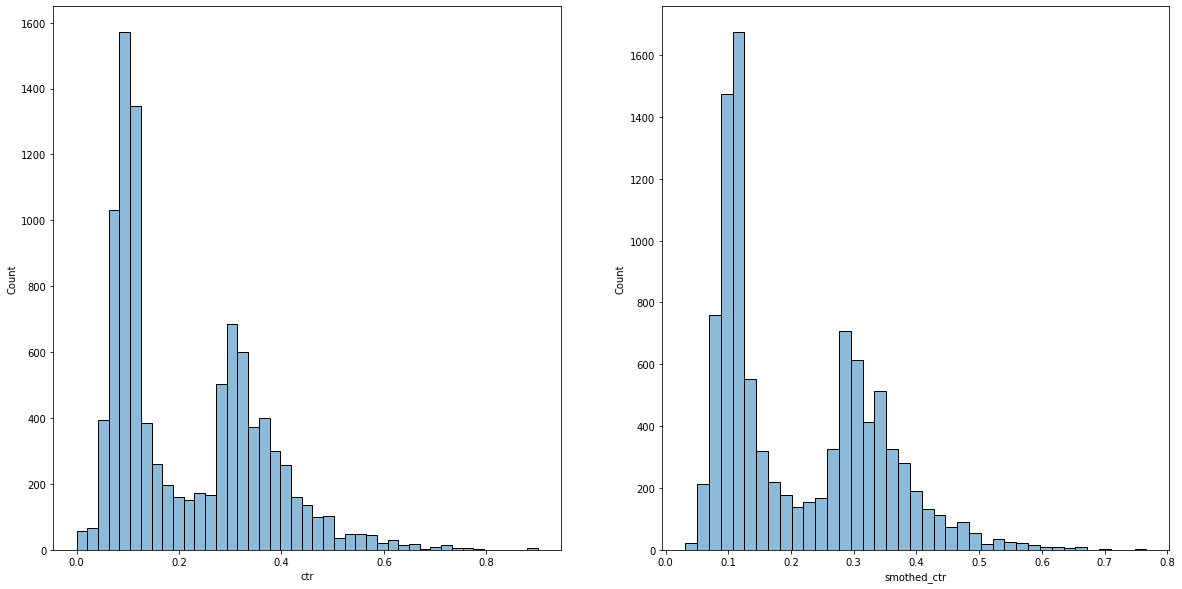

In [25]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

sns.histplot(group2, x ='ctr', alpha=0.5, ax=axs[0])

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group2, x ='smothed_ctr', alpha=0.5, ax=axs[1])

Проведем тесты на нормальность распределения:

In [30]:
stats.normaltest(group1.smothed_ctr)

NormaltestResult(statistic=1291.0702074806425, pvalue=4.442900331529227e-281)

In [31]:
stats.normaltest(group2.smothed_ctr)

NormaltestResult(statistic=751.8427244558492, pvalue=5.488159882451048e-164)

Text(0.5, 1.0, 'experiment (group = 2)')

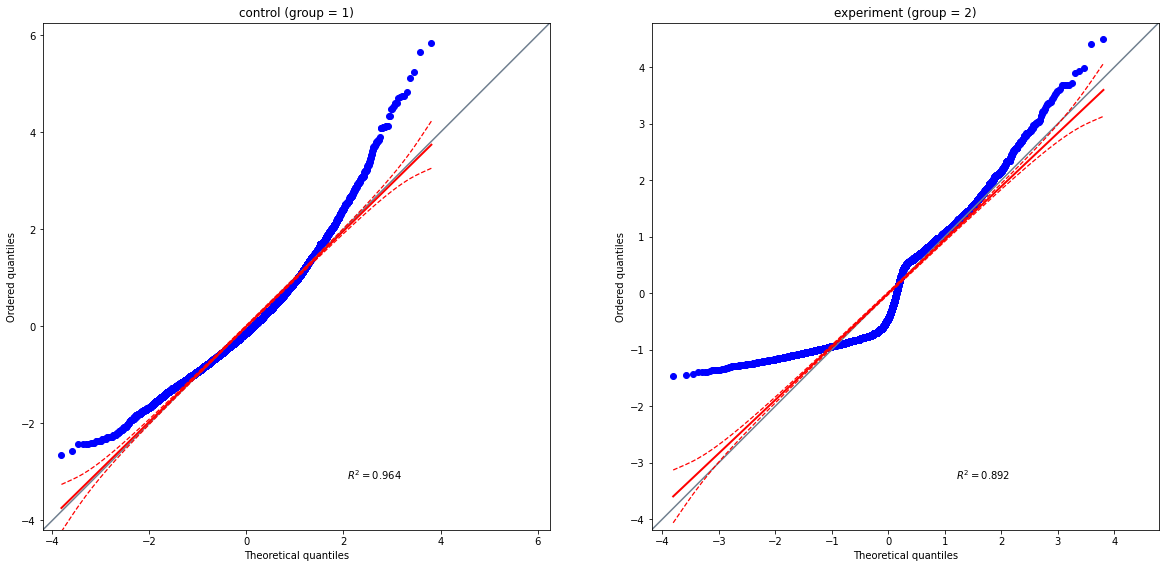

In [32]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

pg.qqplot(x=group1.smothed_ctr, ax=axs[0])
axs[0].set_title('control (group = 1)')
pg.qqplot(x=group2.smothed_ctr, ax=axs[1])
axs[1].set_title('experiment (group = 2)')

Исходя из графиков и тестов на нормальность видно, что сглаживание CTR не приводит наши распределения к нормальности, более того в группе № 1 распределение стало далеко от нормального. 
В любом случае, проведем т-тест и Манна-Уитни:

In [33]:
stats.ttest_ind(group1.smothed_ctr, group2.smothed_ctr, equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

In [34]:
stats.mannwhitneyu(group1.smothed_ctr, 
                   group2.smothed_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55528353.0, pvalue=2.396534039374286e-50)

Убрав шум, результаты тестов тянутся в сторону снижения p-value, а значит и снижения вероятности нулевой гипотезы. Т-тест все равно показывает, что различия в наших выборках не стат значимы. Но мы уже говорили выше о неприменимости т-теста при наших распределениях данных.

* Сравним наши выборки с помощью Пуассоновского бутстрепа:

In [38]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [39]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

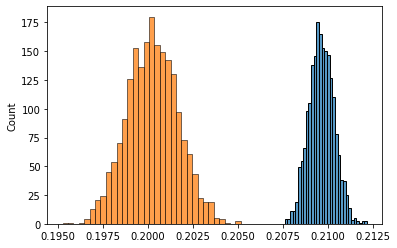

In [41]:
sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

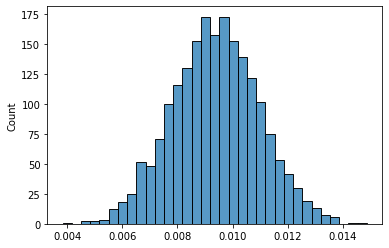

In [42]:
sns.histplot(ctr1 - ctr2)

Здесь мы отчетливо наблюдаем различия CTR в наших группах. Положительная разница в CTR говорит нам, что CTR в контрольной группе (1) выше, чем в тестовой (2).
Исходя из метода, полагаю, что его результатам стоит доверять. Но важно принять во внимание допущение, что наши выборки по составу данных схожи с генеральной совокупностью.

* Далее произведем бакетное преобразование:

In [43]:
q = """
SELECT 
    exp_group, 
    bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (
        SELECT 
            exp_group, 
            xxHash64(user_id)%50 as bucket,
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
        FROM 
            simulator_20241120.feed_actions
        WHERE 
            toDate(time) >= '2024-10-25' and toDate(time) <= '2024-10-31' AND 
            exp_group in (2,1)
        GROUP 
            BY exp_group, bucket, user_id
     )
GROUP BY 
    exp_group, bucket
"""

df = ph.read_clickhouse(q, connection=connection)

Text(0.5, 1.0, 'experiment (group = 2)')

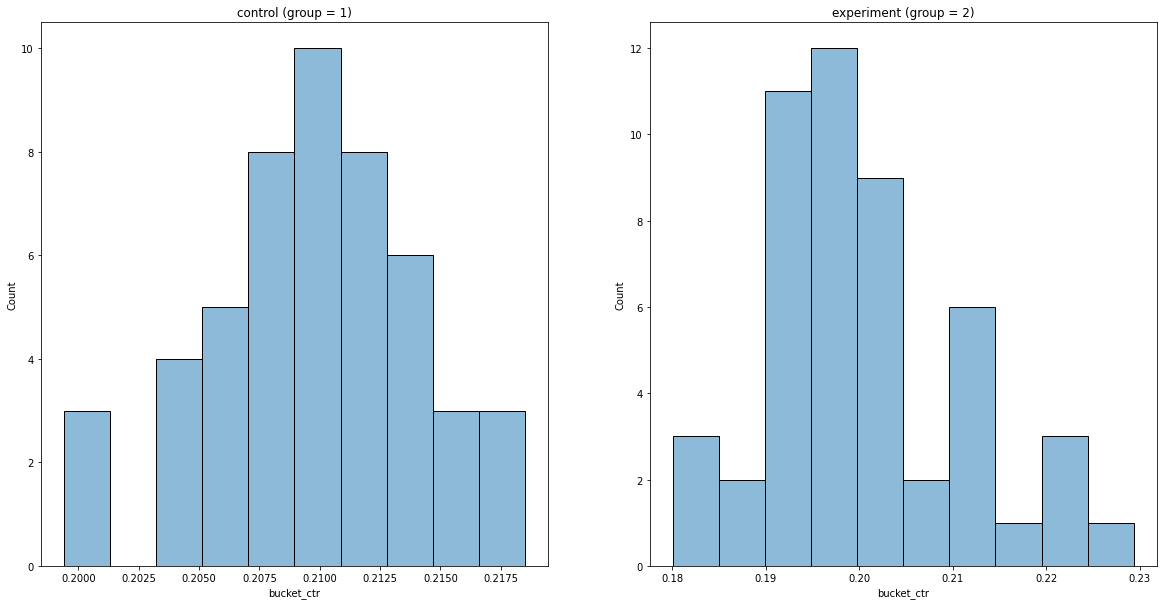

In [44]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

sns.histplot(df[df.exp_group == 1].bucket_ctr, alpha=0.5, ax=axs[0], bins=10)
axs[0].set_title('control (group = 1)')
sns.histplot(df[df.exp_group == 2].bucket_ctr, alpha=0.5, ax=axs[1], bins=10)
axs[1].set_title('experiment (group = 2)')

In [45]:
stats.normaltest(df[df.exp_group == 1].bucket_ctr)

NormaltestResult(statistic=0.8489082689196661, pvalue=0.6541267529461032)

In [46]:
stats.normaltest(df[df.exp_group == 2].bucket_ctr)

NormaltestResult(statistic=4.210772648691096, pvalue=0.12179861141005992)

Text(0.5, 1.0, 'experiment (group = 2)')

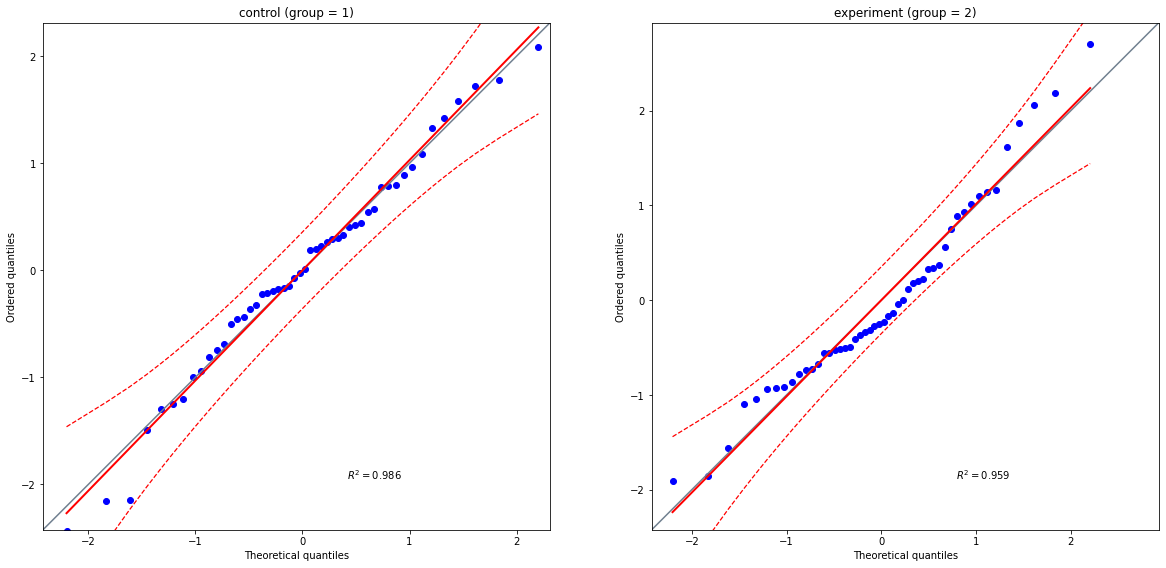

In [47]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

pg.qqplot(x=df[df.exp_group == 1].bucket_ctr, ax=axs[0])
axs[0].set_title('control (group = 1)')
pg.qqplot(x=df[df.exp_group == 2].bucket_ctr, ax=axs[1])
axs[1].set_title('experiment (group = 2)')

In [49]:
pg.normality(data=df, dv='bucket_ctr', group='exp_group')

,W,pval,normal
exp_group,,,
1,0.984154,0.734733,True
2,0.958589,0.077584,True


Можно говорить, что бакетное преобразование приблизило наши распределения к нормальным. Теперь, думаю, т-тесту можно будет доверять:

In [50]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

In [51]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

Тесты показывают стат значимые различия наших выборок. Положительные значения переменной статистики говорят о том, что CTR в контрольной группе больше, чем в тестовой. 

### Аналитическое заключение
Предлагаю делать выводы на основе результатов применения Пуассоновского бустрепа и теста Манна-Уитни, т.к. они не зависят от нормальности распределения выборок. Тесты показывают нам: 
* CTR в наших группах различаются
* у контрольной группы CTR выше, чем у тестовой.

Вывод: предлагаем, пока новый алгоритм рекомендаций постов <font color='green'> **не раскатывать** </font> на всех пользователей.